In [1]:
import numpy as np
from scipy.stats import randint,rv_discrete
import matplotlib.pyplot as plt
from estimator import *
from tqdm import tqdm

In [2]:
def true_delta(supports, myrv1_pmf, myrv2_pmf, epsilon):
    """ computes delta given the P and Q
    """
    delta = 0
    for i in range(len(supports)):
        p1 = myrv1_pmf[i]
        p2 = myrv2_pmf[i]
        delta += max(p2-np.exp(epsilon)*p1,0)
    return delta

In [3]:

S = 100

supports = np.arange(1,S+1,1)


pmfs_uniform = S*[1/S]
myuniform = rv_discrete(name='MyUniform', values=(supports, pmfs_uniform))


alpha = -0.6
pmfs_zipf = 1/supports**alpha /np.sum(1/supports**alpha)
myzipf = rv_discrete(name='MyZipf', values=(supports, pmfs_zipf))




epsilon = 0.4

In [4]:
true_delta12 = true_delta(supports, pmfs_uniform, pmfs_zipf, epsilon = epsilon)


In [5]:
def test_once(n_mean):
    np.random.seed() 

    n1 = np.random.poisson(n_mean)
    n2 = np.random.poisson(n_mean)
    n12 = np.random.poisson(n_mean)
    n22 = np.random.poisson(n_mean)


    rvs1 = myuniform.rvs(size = n1)
    count_1 = {}
    for support in supports:
        count_1[support] = np.count_nonzero(rvs1 == support)


    rvs2 = myzipf.rvs(size = n2)
    count_2 = {}
    for support in supports:
        count_2[support] = np.count_nonzero(rvs2 == support)


    rvs12 = myuniform.rvs(size = n12)
    count_12 = {}
    for support in supports:
        count_12[support] = np.count_nonzero(rvs12 == support)


    rvs22 = myzipf.rvs(size = n22)
    count_22 = {}
    for support in supports:
        count_22[support] = np.count_nonzero(rvs22 == support)
    
    for event in supports:
        if event not in count_1.keys():
            count_1[event] = 0
        if event not in count_2.keys():
            count_2[event] = 0
        if event not in count_12.keys():
            count_12[event] = 0
        if event not in count_22.keys():
            count_22[event] = 0
        
    delta_mle12 = mle_estimator(count_1, count_2,n1, n2, epsilon = epsilon)
    delta_poly12 = opt_estimator(count_1,count_2,count_12,count_22,n1,n2,n12,n22, n_mean, epsilon = epsilon, c_1 = 4, c_2 = 0.1, c_3 = 1.5)
    return [delta_mle12,delta_poly12]


In [6]:
n_list = [100, 316, 1000,3162, 10000,31622, 100000]
r_runs = 100

final_results = []
for n in n_list:
    results = []
    for i in tqdm(range(r_runs)):
        results.append(test_once(n))
    results = np.array(results,dtype = np.float32)
    MSE_mle12 = np.mean((results[:,0]-true_delta12)**2)
    MSE_poly12 = np.mean((results[:,1]-true_delta12)**2)
    std_error_mle12 = np.std((results[:,0]-true_delta12)**2)/np.sqrt(r_runs)
    std_error_poly12 = np.std((results[:,1]-true_delta12)**2)/np.sqrt(r_runs)
    
    output = [MSE_mle12,MSE_poly12,std_error_mle12,std_error_poly12]
    final_results.append(output)

100%|██████████| 100/100 [01:14<00:00,  1.40it/s]


In [7]:
final_results = np.array(final_results)

np.save("synthetic_results.npy", final_results)

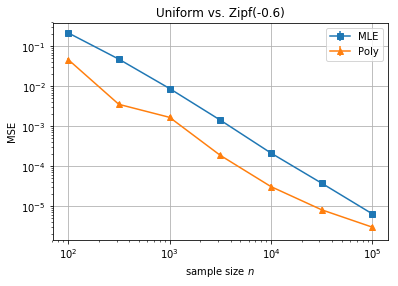

In [8]:
plt.errorbar(n_list, final_results[:,0],final_results[:,2],marker='s',label="MLE")
plt.errorbar(n_list, final_results[:,1],final_results[:,3],marker = '^' ,label="Poly")

plt.xscale('log')
plt.yscale('log')
plt.ylabel("MSE")
plt.xlabel("sample size $n$")
plt.title("Uniform vs. Zipf(-0.6)")
plt.grid()
plt.legend()